# Import Section

In [16]:
# Path
import os

# Data
import numpy as np
from tensorflow.keras.utils import plot_model

# Plot
import matplotlib.pyplot as plt

# Image
from PIL import Image # used in image processing function
from PIL import ImageFilter # used in load_image_pair()

# Tensorflow
import tensorflow as tf

from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import load_img

# For Tensorflow Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import RandomNormal


# Colab Function

In [17]:
def gpu_check():
  """
      Check GPU RAM status. Since google colab share gpu resource amount of its
      user, you want to make sure there are enough GPU RAM that are free to use.
      Recommend at least 3000MB free GPU RAM.
  """
  # memory footprint support libraries/code
  !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
  !pip install gputil
  !pip install psutil
  !pip install humanize
  import psutil
  import humanize
  import os
  import GPUtil as GPU
  GPUs = GPU.getGPUs()
  # XXX: only one GPU on Colab and isn’t guaranteed
  gpu = GPUs[0]
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

# Path Functions

In [18]:
def ensure_dir(path_to_dir):
  try:
      os.makedirs(path_to_dir)
  except FileExistsError:
      # directory already exists
      pass

# Config

In [19]:
"""
    config project in this cell.
"""

# Env, where you running this project
# Google colab: 'colab'
# local machine: 'local'
env = 'local'


In [24]:
""" 
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""

# config dictionary
config = {
    'colab':{
        'data_dir':'/content/drive/My Drive/Colab Notebooks/data',
        'checkpoint_dir':'/content/drive/My Drive/Colab Notebooks/checkpoints',
        'log_dir':'/content/drive/My Drive/Colab Notebooks/logs',
    },
    'local':{
        'data_dir': os.path.join(os.getcwd(), 'data'),
        'checkpoint_dir': os.path.join(os.getcwd(), 'checkpoints'),
        'log_dir': os.path.join(os.getcwd(), 'logs'),
    }
}

# setting all variables
data_dir = config[env]['data_dir']
checkpoint_dir = config[env]['checkpoint_dir']
log_dir = config[env]['log_dir']

# mount google drive
if env == 'colab':
  # Google Drive
  from google.colab import drive
  # mount google dirve
  drive.mount('/content/drive')
  # ensure dir exsits
  ensure_dir(checkpoint_dir)
  # check GPU
  gpu_check()

# Image Processing Function

In [25]:
def bicubic_rescale(image, scale):
  """
      Rescale image using bicubic interpolation.
      
      Args:
        image: image
        scale: use integer for up scaling. use 1/integer for down scaling
  """
  # make sure scale is valid
  if isinstance(scale, (float, int)):
    size = (np.array(image.size) * scale).astype(int)
  '''
  WARNING
  image.resize might lead to image displacement
  https://hackernoon.com/how-tensorflows-tf-image-resize-stole-60-days-of-my-life-aba5eb093f35
  switch to tf.image.resize_bicubic
  '''
  return image.resize(size, resample=Image.BICUBIC)


def modcrop(image, scale):
  """
      To scale down the original image, there must be no remainder while scaling
      operation.
      
      All we want to do in here is to subtract the remainder from height and 
      width of original image size, and cut the original image to the new size.
      
      Args:
        image: original image
        scale: must be int
  """
  if not isinstance(scale, int):
    raise Exception('utils.modcrop: scale must be int')
  size = np.array(image.size)
  size -= size % scale
  return image.crop([0, 0, *size])

# Data Preprocessing

In [26]:
def load_image_pair(path, scale=3, greyscale=False, same_size=False):
  """
      Down scaling a hight resolution image to a low resolution image and
      return both of them.
      
      Args:
        path: image path
        scale: scale of down scaling, must be a int
        greyscale: return only Y channel
  """
  image = load_img(path)
  
  if greyscale:
    image = image.convert('YCbCr')
    Y, Cb, Cr = image.split()
    image = Y
  else:
    image = image.convert('RGB')

  hr_image = modcrop(image, scale)
  lr_image = hr_image.filter(ImageFilter.GaussianBlur(radius=2))
  lr_image = bicubic_rescale(lr_image, 1 / scale)
  lr_image = bicubic_rescale(lr_image, scale)
  return lr_image, hr_image


def random_crop(lr_image, hr_image, random_crop_size):
  """
      randomly crop both lr and hr image at the same position.
      
      Args:
          random_crop_size: size of sub image, array, example:[32,32]
  """
  # Note: image_data_format is 'channel_last'
  height, width = lr_image.size
  dy, dx = random_crop_size
  x = np.random.randint(0, width - dx + 1)
  y = np.random.randint(0, height - dy + 1)
  return lr_image.crop([x, y, x + dx, y + dy]), hr_image.crop([x, y, x + dx, y + dy])


def generate_sub_images(lr_image, hr_image, size=[32, 32], num_of_image=1):
  """
      Cut image into sub images.
      
      Args:
        image: image
        size: size of sub image
        number_of_image: how many sub image you want to crop for image
  """
  for i in range(num_of_image):
    yield random_crop(lr_image, hr_image, size)
            
            
class Dataset:
  
  def __init__(self):
    self.lr_sub_size = 0
    self.lr_sub_stride = 0
    self.hr_sub_size = 0
    self.hr_sub_stride = 0
    self.lr_array = []
    self.hr_array = []
    
    
  def load_set(self, dataset_name, lr_sub_size, lr_sub_stride, scale, same_size=False, greyscale=False):
    """
        Load all image from a directory and cut them into small sub image.

        Args:
          dataset_name: name of dir of the data set
          lr_sub_size: low resolution sub image size
          lr_sub_stride: stride when crop sub image
          scale: down scale value
          same_size: hr, lr have the same size
          greyscale: return only Y channel
    """
    if not all(isinstance(i, int) for i in [lr_sub_size, lr_sub_stride, scale]):
      raise Exception('utils.load_set: lr_sub_size, stride, scale must be int')
      
    self.lr_sub_size = lr_sub_size
    self.lr_sub_stride = lr_sub_stride
      
    # compute parameters for hight resolution image
    if same_size:
      self.hr_sub_size = lr_sub_size
      self.hr_sub_stride = lr_sub_stride
    else:
      self.hr_sub_size = lr_sub_size * scale
      self.hr_sub_stride = lr_sub_stride * scale
    
    for file_name in os.listdir(os.path.join(data_dir, dataset_name)):
      path = os.path.join(data_dir, dataset_name, file_name)
      lr_image, hr_image = load_image_pair(str(path), scale=scale, greyscale=greyscale, same_size=same_size)
      self.lr_array.append(lr_image)
      self.hr_array.append(hr_image)
      
      
  def show_set(self):
    """
      view the first 3 image of the dataset
    """
    f, axarr = plt.subplots(2, 3, figsize=(18,18))
    
    # Plot images in subplot
    axarr[1,2].imshow(self.hr_array[0])
    axarr[1,1].imshow(self.hr_array[1])
    axarr[1,0].imshow(self.hr_array[2])
    axarr[0,2].imshow(self.lr_array[0])
    axarr[0,1].imshow(self.lr_array[1])
    axarr[0,0].imshow(self.lr_array[2])
    
    # Disable axis
    axarr[1,2].axis("off")
    axarr[1,1].axis("off")
    axarr[1,0].axis("off")
    axarr[0,2].axis("off")
    axarr[0,1].axis("off")
    axarr[0,0].axis("off")
   
    plt.show()
    
  
  def sub_image_set(self, random_crop_size=[32,32], num_of_image=1):
    """
      return the sub image dataset
    """
    lr_sub_arrays = []
    hr_sub_arrays = []
    lr_batch = []
    hr_batch = []
    height, width = self.hr_array[0].size
    dy, dx = random_crop_size
    
    # crop low resolution image and high resolution image at same position
    for lr_image, hr_image in zip(self.lr_array, self.hr_array):
      for i in range(num_of_image):
        x = np.random.randint(0, width - dx + 1)
        y = np.random.randint(0, height - dy + 1)
        
        lr_batch += [lr_image.crop([x, y, x + dx, y + dy])]
        hr_batch += [hr_image.crop([x, y, x + dx, y + dy])]
        
      lr_sub_arrays += [img_to_array(img) for img in lr_batch]
      hr_sub_arrays += [img_to_array(img) for img in hr_batch]
    
    # convert list to np.array
    x = np.stack(lr_sub_arrays)
    y = np.stack(hr_sub_arrays)

    return x, y 

  def clear_set(self):
    """
      reset Dataset
    """
    self.lr_array = []
    self.hr_array = []
    
    
# TODO
# normalization?
# Seng: add a layer called BatchNormalization in model
# https://keras.io/layers/normalization/

# Helper Function

In [28]:
def train(
    model,
    train_set,
    val_set,
    epochs=1,
    steps_per_epoch=30,
    validation_steps=3,
    resume=True):
  """
    train function for all model.
    
    
  """
  path_to_weight_file = os.path.join(checkpoint_dir,model.name)

  # define callbacks
  callbacks = [
    # Save checkpoints of model at regular intervals
    tf.keras.callbacks.ModelCheckpoint(
        filepath=path_to_weight_file,
        save_best_only=True
    ),
    # Write TensorBoard logs to `./logs` directory
      tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  ]
  
  # inherit weights
  if resume:
    model.load_weights(path_to_weight_file)
  
  # Train
  history = model.fit(train_set, epochs=epochs,verbose=1, callbacks=callbacks, steps_per_epoch=steps_per_epoch,
            validation_data=val_set, validation_steps=validation_steps)

  # plot metrics
  plot_based_loss(history)
  plot_based_accuracy(history)
  

def test(model, test_set, steps=30, metrics=None):
  # test
  model.evaluate(test_set, steps=steps)
  
def reload_model(model):
  """
    load weight into model
  """
  path_to_weight_file = os.path.join(checkpoint_dir,model.name)
  model.load_weights(path_to_weight_file)
  
def plot_based_loss(history):
  """
    Plot training & validation loss values
    history: a dictionary recording training loss values and metrics values at successive epochs
  """
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss: Mean Squared Error')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.ylim(0,2000)
  plt.show()
  
def plot_based_accuracy(history):
  """
    Plot training & validation accuracy values
    history: a dictionary recording training loss values and metrics values at successive epochs
  """
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy: Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

# Model

In [29]:
class SRCNN:
  """
    name: the name of the model
    img_size: the size of the input image
    channel: the number of channels in the input image
    f1: the size of filter (must be odd #)
    n1: the number of filters apply on layer 1
    n2: the number of filters apply on layer 2
    f3: the size of filter (must be odd #)


    from: https://arxiv.org/abs/1501.00092
  """ 
  def build_model(img_size=32, channel=1, f1=9, n1=64, n2=32, f3=5):
    model = Sequential(name='srcnn')
    initializer = RandomNormal(mean=0.0, stddev=0.001)
    model.add(Conv2D(filters=n1, kernel_size=f1, padding='same', activation='relu',
                     kernel_initializer=initializer, input_shape=(img_size,img_size,channel)))
    model.add(Conv2D(filters=n2, kernel_size=1, padding='same', activation='relu',
                    kernel_initializer=initializer))
    model.add(Conv2D(filters=channel, kernel_size=f3, padding='same', activation='linear',
                    kernel_initializer=initializer))
  
    # either SGD or Adam
    #optimizer = SGD(lr=0.0003)
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['acc'])
      
    return model
    

    


# Model Training

## Model Config

In [30]:
# size of sub image
size = 32

# strde when crop image
stride = 14

# upscaling factor
scale = 1

# batch size
batch = 32

# size of low resolution and high resolution image is the same?
same_size = True

# number of sub image of each image
num_of_image = 30

# greyscale ON or OFF? if ON, img will only contain Y channel
greyscale = True

# whcih training dataset you want to use?
train_dataset_dir = '91-image'

# which validation dataset you want to use?
val_dataset_dir = 'Set5'

# which testing dataset you want to use?
test_dataset_dir = 'Set14'

# which model you want to train or test?
model = SRCNN.build_model(size)

# print model details below
print("Model Name: {}".format(model.name))
model.summary()

# epochs
epochs = 15000

# steps_per_epoch
steps_per_epoch = 30

# validation_steps
validation_steps = 3

# resume last traning?
resume = False
    

Model Name: srcnn
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        5248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 1)         801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


## Make Data

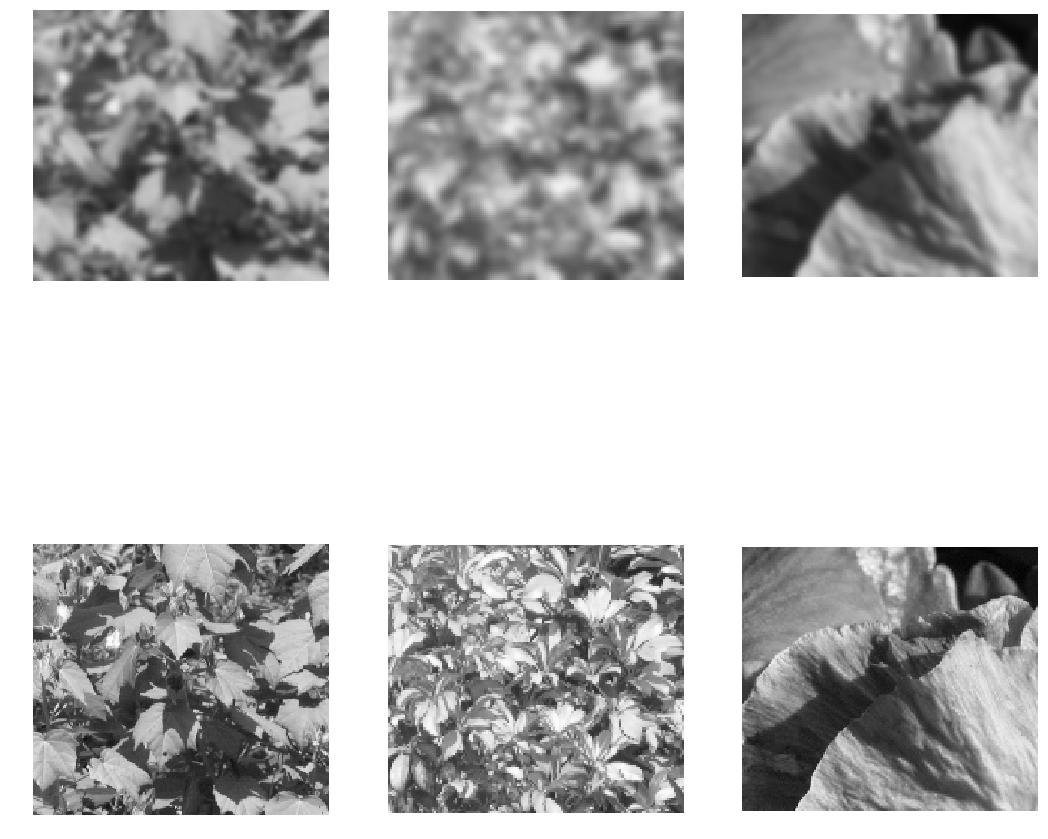

In [31]:
""" 
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
dataset = Dataset()

# load tranning dataset
dataset.load_set(train_dataset_dir, size, stride, scale, same_size, greyscale)
dataset.show_set()
train_lr, train_hr = dataset.sub_image_set([size, size], num_of_image)

# make tf.data dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_lr, train_hr))
train_dataset = train_dataset.batch(batch)
train_dataset = train_dataset.repeat()

# load validation dataset
dataset.clear_set()
dataset.load_set(val_dataset_dir, size, stride, scale, same_size, greyscale)
val_lr, val_hr = dataset.sub_image_set([size, size], num_of_image)
# make tf.data dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_lr, val_hr))
val_dataset = val_dataset.batch(batch//10)
val_dataset = val_dataset.repeat()

In [32]:
""" 
    _________
    | Train |
    ————-
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
train(model, train_dataset, val_dataset, epochs, steps_per_epoch, validation_steps, resume)

Epoch 1/15000
30/30 [==============================] - 7s 224ms/step - loss: 12008.0186 - acc: 0.1553 - val_loss: 4491.3835 - val_acc: 0.0046
Epoch 2/15000
30/30 [==============================] - 0s 6ms/step - loss: 2053.0381 - acc: 0.1356 - val_loss: 1237.2904 - val_acc: 0.0203
Epoch 3/15000
30/30 [==============================] - 0s 6ms/step - loss: 1470.5484 - acc: 0.1551 - val_loss: 2154.7694 - val_acc: 0.0109
Epoch 4/15000
30/30 [==============================] - 0s 6ms/step - loss: 1360.7342 - acc: 0.1971 - val_loss: 1730.9844 - val_acc: 0.0165
Epoch 5/15000
30/30 [==============================] - 0s 6ms/step - loss: 1214.0867 - acc: 0.2590 - val_loss: 1346.1825 - val_acc: 0.0102
Epoch 6/15000
30/30 [==============================] - 0s 6ms/step - loss: 1171.0132 - acc: 0.2749 - val_loss: 1410.2711 - val_acc: 0.0144
Epoch 7/15000
30/30 [==============================] - 0s 6ms/step - loss: 1082.2983 - acc: 0.2404 - val_loss: 1313.7111 - val_acc: 0.2892
Epoch 8/15000
30/30 [===

30/30 [==============================] - 0s 6ms/step - loss: 214.0381 - acc: 0.2543 - val_loss: 19.8713 - val_acc: 0.7531
Epoch 61/15000
30/30 [==============================] - 0s 5ms/step - loss: 248.3897 - acc: 0.0896 - val_loss: 63.9552 - val_acc: 0.0430
Epoch 62/15000
30/30 [==============================] - 0s 6ms/step - loss: 200.5883 - acc: 0.2580 - val_loss: 108.0765 - val_acc: 0.0373
Epoch 63/15000
30/30 [==============================] - 0s 6ms/step - loss: 219.0920 - acc: 0.1007 - val_loss: 66.4144 - val_acc: 0.0553
Epoch 64/15000
30/30 [==============================] - 0s 6ms/step - loss: 200.4373 - acc: 0.2590 - val_loss: 27.9588 - val_acc: 0.6412
Epoch 65/15000
30/30 [==============================] - 0s 6ms/step - loss: 238.3511 - acc: 0.1021 - val_loss: 38.1839 - val_acc: 0.5884
Epoch 66/15000
30/30 [==============================] - 0s 6ms/step - loss: 200.4819 - acc: 0.2574 - val_loss: 27.8898 - val_acc: 0.7516
Epoch 67/15000
30/30 [==============================] -

30/30 [==============================] - 0s 6ms/step - loss: 241.2414 - acc: 0.1136 - val_loss: 87.0142 - val_acc: 0.8737
Epoch 120/15000
30/30 [==============================] - 0s 6ms/step - loss: 229.1062 - acc: 0.1120 - val_loss: 351.7990 - val_acc: 0.5171
Epoch 121/15000
30/30 [==============================] - 0s 6ms/step - loss: 165.1324 - acc: 0.2270 - val_loss: 89.3802 - val_acc: 0.0337
Epoch 122/15000
30/30 [==============================] - 0s 6ms/step - loss: 266.5077 - acc: 0.1046 - val_loss: 96.6695 - val_acc: 0.0468
Epoch 123/15000
30/30 [==============================] - 0s 6ms/step - loss: 212.8972 - acc: 0.2108 - val_loss: 59.5511 - val_acc: 0.0690
Epoch 124/15000
30/30 [==============================] - 0s 6ms/step - loss: 186.0281 - acc: 0.1275 - val_loss: 17.9234 - val_acc: 0.6513
Epoch 125/15000
30/30 [==============================] - 0s 6ms/step - loss: 285.5850 - acc: 0.0969 - val_loss: 31.5256 - val_acc: 0.5592
Epoch 126/15000
30/30 [==========================

30/30 [==============================] - 0s 5ms/step - loss: 161.5888 - acc: 0.2263 - val_loss: 191.3910 - val_acc: 0.6188
Epoch 179/15000
30/30 [==============================] - 0s 5ms/step - loss: 181.0905 - acc: 0.1069 - val_loss: 81.5842 - val_acc: 0.8727
Epoch 180/15000
30/30 [==============================] - 0s 5ms/step - loss: 175.8112 - acc: 0.2442 - val_loss: 332.8446 - val_acc: 0.5115
Epoch 181/15000
30/30 [==============================] - 0s 5ms/step - loss: 188.0615 - acc: 0.1228 - val_loss: 7.3473 - val_acc: 0.7954
Epoch 182/15000
30/30 [==============================] - 0s 5ms/step - loss: 169.7452 - acc: 0.2210 - val_loss: 20.5707 - val_acc: 0.5837
Epoch 183/15000
30/30 [==============================] - 0s 5ms/step - loss: 166.3744 - acc: 0.2048 - val_loss: 40.6247 - val_acc: 0.6817
Epoch 184/15000
30/30 [==============================] - 0s 5ms/step - loss: 185.7760 - acc: 0.1501 - val_loss: 60.8760 - val_acc: 0.1923
Epoch 185/15000
30/30 [==========================

30/30 [==============================] - 0s 5ms/step - loss: 242.8266 - acc: 0.1057 - val_loss: 32.3621 - val_acc: 0.3315
Epoch 238/15000
30/30 [==============================] - 0s 5ms/step - loss: 186.5351 - acc: 0.2275 - val_loss: 17.8054 - val_acc: 0.6966
Epoch 239/15000
30/30 [==============================] - 0s 5ms/step - loss: 176.2112 - acc: 0.1046 - val_loss: 26.2244 - val_acc: 0.6360
Epoch 240/15000
30/30 [==============================] - 0s 5ms/step - loss: 269.0328 - acc: 0.1063 - val_loss: 13.0027 - val_acc: 0.7501
Epoch 241/15000
30/30 [==============================] - 0s 5ms/step - loss: 165.4379 - acc: 0.2211 - val_loss: 276.3755 - val_acc: 0.4575
Epoch 242/15000
30/30 [==============================] - 0s 5ms/step - loss: 233.5704 - acc: 0.1045 - val_loss: 51.5883 - val_acc: 0.8078
Epoch 243/15000
30/30 [==============================] - 0s 5ms/step - loss: 180.7638 - acc: 0.2033 - val_loss: 328.1222 - val_acc: 0.4324
Epoch 244/15000
30/30 [=========================

30/30 [==============================] - 0s 5ms/step - loss: 148.9312 - acc: 0.2186 - val_loss: 41.1466 - val_acc: 0.5791
Epoch 297/15000
30/30 [==============================] - 0s 5ms/step - loss: 188.7623 - acc: 0.1451 - val_loss: 17.4826 - val_acc: 0.7287
Epoch 298/15000
30/30 [==============================] - 0s 5ms/step - loss: 135.0641 - acc: 0.2490 - val_loss: 48.9897 - val_acc: 0.5169
Epoch 299/15000
30/30 [==============================] - 0s 5ms/step - loss: 142.9558 - acc: 0.2196 - val_loss: 68.1387 - val_acc: 0.4825
Epoch 300/15000
30/30 [==============================] - 0s 5ms/step - loss: 178.2908 - acc: 0.1295 - val_loss: 47.1661 - val_acc: 0.4722
Epoch 301/15000
30/30 [==============================] - 0s 5ms/step - loss: 140.9434 - acc: 0.2556 - val_loss: 31.8006 - val_acc: 0.0979
Epoch 302/15000
30/30 [==============================] - 0s 5ms/step - loss: 146.0116 - acc: 0.1889 - val_loss: 75.3819 - val_acc: 0.0654
Epoch 303/15000
30/30 [===========================

30/30 [==============================] - 0s 5ms/step - loss: 179.1080 - acc: 0.0961 - val_loss: 67.3206 - val_acc: 0.0769
Epoch 356/15000
30/30 [==============================] - 0s 5ms/step - loss: 200.0875 - acc: 0.1943 - val_loss: 49.1820 - val_acc: 0.0572
Epoch 357/15000
30/30 [==============================] - 0s 5ms/step - loss: 155.2839 - acc: 0.1704 - val_loss: 18.5011 - val_acc: 0.4161
Epoch 358/15000
30/30 [==============================] - 0s 5ms/step - loss: 232.5058 - acc: 0.1107 - val_loss: 14.7669 - val_acc: 0.6980
Epoch 359/15000
30/30 [==============================] - 0s 5ms/step - loss: 136.6794 - acc: 0.2527 - val_loss: 23.0438 - val_acc: 0.6425
Epoch 360/15000
30/30 [==============================] - 0s 5ms/step - loss: 175.8329 - acc: 0.1273 - val_loss: 11.3140 - val_acc: 0.7548
Epoch 361/15000
30/30 [==============================] - 0s 5ms/step - loss: 192.1162 - acc: 0.2065 - val_loss: 28.0987 - val_acc: 0.1221
Epoch 362/15000
30/30 [===========================

30/30 [==============================] - 0s 5ms/step - loss: 142.0683 - acc: 0.2341 - val_loss: 12.2070 - val_acc: 0.6406
Epoch 415/15000
30/30 [==============================] - 0s 5ms/step - loss: 122.1364 - acc: 0.2383 - val_loss: 23.0958 - val_acc: 0.4937
Epoch 416/15000
30/30 [==============================] - 0s 5ms/step - loss: 148.5705 - acc: 0.1702 - val_loss: 17.2067 - val_acc: 0.7220
Epoch 417/15000
30/30 [==============================] - 0s 6ms/step - loss: 146.2358 - acc: 0.2345 - val_loss: 98.9186 - val_acc: 0.5239
Epoch 418/15000
30/30 [==============================] - 0s 5ms/step - loss: 118.3652 - acc: 0.2332 - val_loss: 139.1506 - val_acc: 0.6107
Epoch 419/15000
30/30 [==============================] - 0s 5ms/step - loss: 132.1512 - acc: 0.2567 - val_loss: 64.6037 - val_acc: 0.8373
Epoch 420/15000
30/30 [==============================] - 0s 5ms/step - loss: 129.9362 - acc: 0.2139 - val_loss: 274.4367 - val_acc: 0.4737
Epoch 421/15000
30/30 [=========================

30/30 [==============================] - 0s 5ms/step - loss: 182.8361 - acc: 0.2302 - val_loss: 31.7065 - val_acc: 0.1098
Epoch 474/15000
30/30 [==============================] - 0s 5ms/step - loss: 130.8583 - acc: 0.1411 - val_loss: 7.8872 - val_acc: 0.6720
Epoch 475/15000
30/30 [==============================] - 0s 5ms/step - loss: 201.6250 - acc: 0.1495 - val_loss: 20.5136 - val_acc: 0.5014
Epoch 476/15000
30/30 [==============================] - 0s 5ms/step - loss: 114.7529 - acc: 0.2325 - val_loss: 16.8044 - val_acc: 0.7437
Epoch 477/15000
30/30 [==============================] - 0s 5ms/step - loss: 216.6546 - acc: 0.1153 - val_loss: 91.4511 - val_acc: 0.5393
Epoch 478/15000
30/30 [==============================] - 0s 5ms/step - loss: 114.4980 - acc: 0.2454 - val_loss: 133.5832 - val_acc: 0.6170
Epoch 479/15000
30/30 [==============================] - 0s 5ms/step - loss: 176.2558 - acc: 0.1235 - val_loss: 64.1946 - val_acc: 0.8637
Epoch 480/15000
30/30 [===========================

30/30 [==============================] - 0s 5ms/step - loss: 134.5280 - acc: 0.2859 - val_loss: 18.6085 - val_acc: 0.5858
Epoch 533/15000
30/30 [==============================] - 0s 5ms/step - loss: 130.0358 - acc: 0.2568 - val_loss: 29.6592 - val_acc: 0.6825
Epoch 534/15000
30/30 [==============================] - 0s 5ms/step - loss: 114.3759 - acc: 0.3111 - val_loss: 27.0889 - val_acc: 0.2399
Epoch 535/15000
30/30 [==============================] - 0s 5ms/step - loss: 133.6575 - acc: 0.2707 - val_loss: 56.5879 - val_acc: 0.0815
Epoch 536/15000
30/30 [==============================] - 0s 5ms/step - loss: 114.6963 - acc: 0.2820 - val_loss: 37.4687 - val_acc: 0.1105
Epoch 537/15000
30/30 [==============================] - 0s 5ms/step - loss: 130.3645 - acc: 0.2674 - val_loss: 15.5882 - val_acc: 0.3436
Epoch 538/15000
30/30 [==============================] - 0s 5ms/step - loss: 126.0965 - acc: 0.2702 - val_loss: 13.4689 - val_acc: 0.7001
Epoch 539/15000
30/30 [===========================

30/30 [==============================] - 0s 5ms/step - loss: 154.3103 - acc: 0.2458 - val_loss: 174.6322 - val_acc: 0.4658
Epoch 592/15000
30/30 [==============================] - 0s 5ms/step - loss: 124.6640 - acc: 0.1394 - val_loss: 50.2655 - val_acc: 0.8091
Epoch 593/15000
30/30 [==============================] - 0s 5ms/step - loss: 141.4625 - acc: 0.2370 - val_loss: 243.6511 - val_acc: 0.4416
Epoch 594/15000
30/30 [==============================] - 0s 5ms/step - loss: 134.8112 - acc: 0.1399 - val_loss: 53.0249 - val_acc: 0.8528
Epoch 595/15000
30/30 [==============================] - 0s 5ms/step - loss: 166.9659 - acc: 0.2041 - val_loss: 8.6428 - val_acc: 0.6942
Epoch 596/15000
30/30 [==============================] - 0s 5ms/step - loss: 134.2502 - acc: 0.1748 - val_loss: 36.2958 - val_acc: 0.5792
Epoch 597/15000
30/30 [==============================] - 0s 5ms/step - loss: 168.6085 - acc: 0.1536 - val_loss: 14.0014 - val_acc: 0.7275
Epoch 598/15000
30/30 [==========================

30/30 [==============================] - 0s 6ms/step - loss: 136.6219 - acc: 0.1487 - val_loss: 33.7679 - val_acc: 0.4965
Epoch 651/15000
30/30 [==============================] - 0s 5ms/step - loss: 204.7299 - acc: 0.1128 - val_loss: 23.7360 - val_acc: 0.1168
Epoch 652/15000
30/30 [==============================] - 0s 5ms/step - loss: 129.0331 - acc: 0.2173 - val_loss: 67.7860 - val_acc: 0.0477
Epoch 653/15000
30/30 [==============================] - 0s 5ms/step - loss: 116.2833 - acc: 0.1314 - val_loss: 30.1067 - val_acc: 0.0955
Epoch 654/15000
30/30 [==============================] - 0s 5ms/step - loss: 203.1920 - acc: 0.1044 - val_loss: 21.9706 - val_acc: 0.1281
Epoch 655/15000
30/30 [==============================] - 0s 5ms/step - loss: 201.9440 - acc: 0.1719 - val_loss: 52.8555 - val_acc: 0.0946
Epoch 656/15000
30/30 [==============================] - 0s 5ms/step - loss: 149.5369 - acc: 0.1953 - val_loss: 35.0948 - val_acc: 0.1131
Epoch 657/15000
30/30 [===========================

30/30 [==============================] - 0s 5ms/step - loss: 108.9544 - acc: 0.2289 - val_loss: 19.2486 - val_acc: 0.6889
Epoch 710/15000
30/30 [==============================] - 0s 5ms/step - loss: 124.3385 - acc: 0.2213 - val_loss: 8.8632 - val_acc: 0.7578
Epoch 711/15000
30/30 [==============================] - 0s 5ms/step - loss: 130.8966 - acc: 0.1480 - val_loss: 24.7824 - val_acc: 0.0960
Epoch 712/15000
30/30 [==============================] - 0s 5ms/step - loss: 130.2934 - acc: 0.2322 - val_loss: 69.5617 - val_acc: 0.0480
Epoch 713/15000
30/30 [==============================] - 0s 5ms/step - loss: 121.3384 - acc: 0.1352 - val_loss: 28.1525 - val_acc: 0.1204
Epoch 714/15000
30/30 [==============================] - 0s 5ms/step - loss: 142.8676 - acc: 0.2379 - val_loss: 10.2875 - val_acc: 0.6615
Epoch 715/15000
30/30 [==============================] - 0s 5ms/step - loss: 124.0399 - acc: 0.1260 - val_loss: 18.8468 - val_acc: 0.5515
Epoch 716/15000
30/30 [============================

30/30 [==============================] - 0s 5ms/step - loss: 176.8701 - acc: 0.1238 - val_loss: 112.8329 - val_acc: 0.6123
Epoch 769/15000
30/30 [==============================] - 0s 5ms/step - loss: 128.9421 - acc: 0.2122 - val_loss: 56.1330 - val_acc: 0.8363
Epoch 770/15000
30/30 [==============================] - 0s 5ms/step - loss: 123.4387 - acc: 0.1368 - val_loss: 239.6998 - val_acc: 0.4769
Epoch 771/15000
30/30 [==============================] - 0s 5ms/step - loss: 199.5372 - acc: 0.1062 - val_loss: 22.6186 - val_acc: 0.1085
Epoch 772/15000
30/30 [==============================] - 0s 5ms/step - loss: 109.1244 - acc: 0.2567 - val_loss: 58.8513 - val_acc: 0.0577
Epoch 773/15000
30/30 [==============================] - 0s 5ms/step - loss: 139.8324 - acc: 0.1059 - val_loss: 28.0174 - val_acc: 0.1424
Epoch 774/15000
30/30 [==============================] - 0s 6ms/step - loss: 181.5781 - acc: 0.1205 - val_loss: 7.8675 - val_acc: 0.6612
Epoch 775/15000
30/30 [==========================

30/30 [==============================] - 0s 6ms/step - loss: 106.9282 - acc: 0.2145 - val_loss: 75.6825 - val_acc: 0.5272
Epoch 828/15000
30/30 [==============================] - 0s 5ms/step - loss: 127.8012 - acc: 0.1374 - val_loss: 110.4712 - val_acc: 0.5934
Epoch 829/15000
30/30 [==============================] - 0s 5ms/step - loss: 116.5835 - acc: 0.2456 - val_loss: 55.7869 - val_acc: 0.8103
Epoch 830/15000
30/30 [==============================] - 0s 5ms/step - loss: 119.7832 - acc: 0.1298 - val_loss: 232.5755 - val_acc: 0.4666
Epoch 831/15000
30/30 [==============================] - 0s 5ms/step - loss: 110.5826 - acc: 0.2219 - val_loss: 6.5092 - val_acc: 0.7479
Epoch 832/15000
30/30 [==============================] - 0s 6ms/step - loss: 98.9977 - acc: 0.2292 - val_loss: 16.1564 - val_acc: 0.5617
Epoch 833/15000
30/30 [==============================] - 0s 5ms/step - loss: 124.9101 - acc: 0.1367 - val_loss: 28.3496 - val_acc: 0.6427
Epoch 834/15000
30/30 [===========================

SystemError: <built-in function EventsWriter_Flush> returned a result with an error set

In [0]:
""" 
    ___________
    | Reload  |
    ————---
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
reload_model(model)

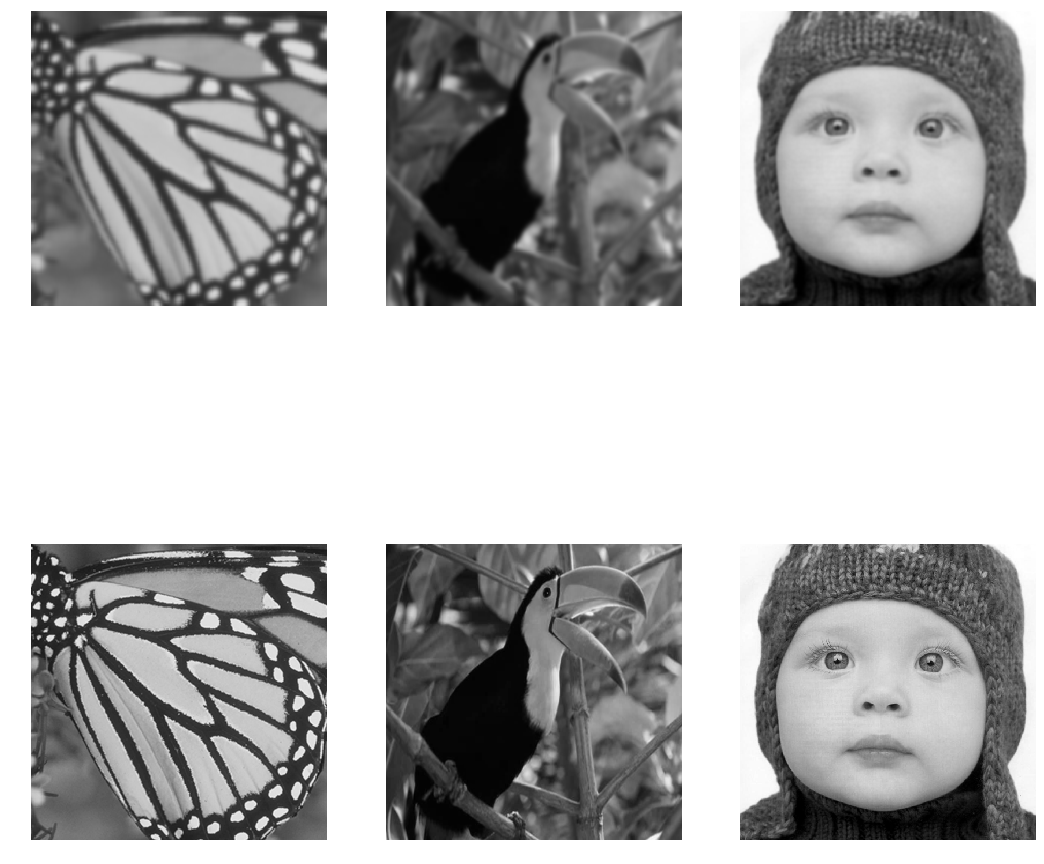

In [28]:
""" 
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
# load test dataset
dataset.load_set(test_dataset_dir, size, stride, scale, same_size, greyscale)
dataset.show_set()
test_lr, test_hr = dataset.sub_image_set([size, size], num_of_image)

# make tf.data dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_lr, test_hr))
test_dataset = test_dataset.batch(batch)
test_dataset = test_dataset.repeat()

In [29]:
""" 
    _________
    | Test  |
    ————-
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
test(model, test_dataset, steps=30, metrics=None)

30/30 [==============================] - 0s 6ms/step - loss: 84.9913 - acc: 0.4465
